In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [4]:
print(x_train.shape)

(60000, 28, 28)


In [5]:
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [6]:
noise_factor = 0.2
x_train_noisy = x_train+noise_factor*tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test+noise_factor*tf.random.normal(shape=x_test.shape)

In [7]:
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

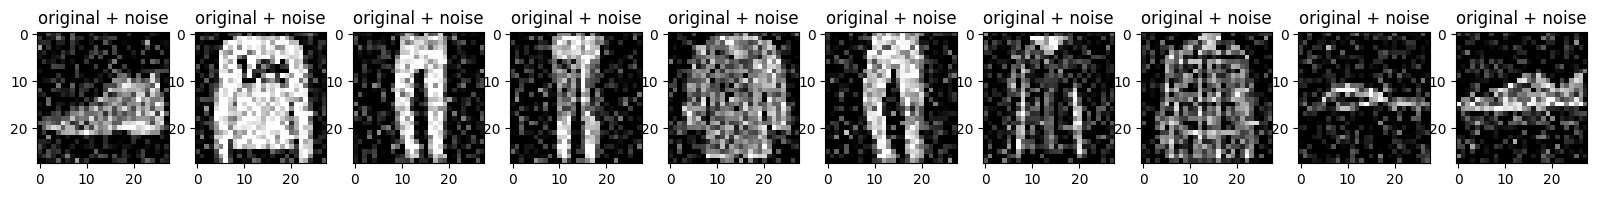

In [9]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i])
    plt.gray()
plt.show()

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16,(3,3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8,(3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 20s 5ms/step - loss: 0.0185 - val_loss: 0.0106
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 5/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - loss: 

In [13]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

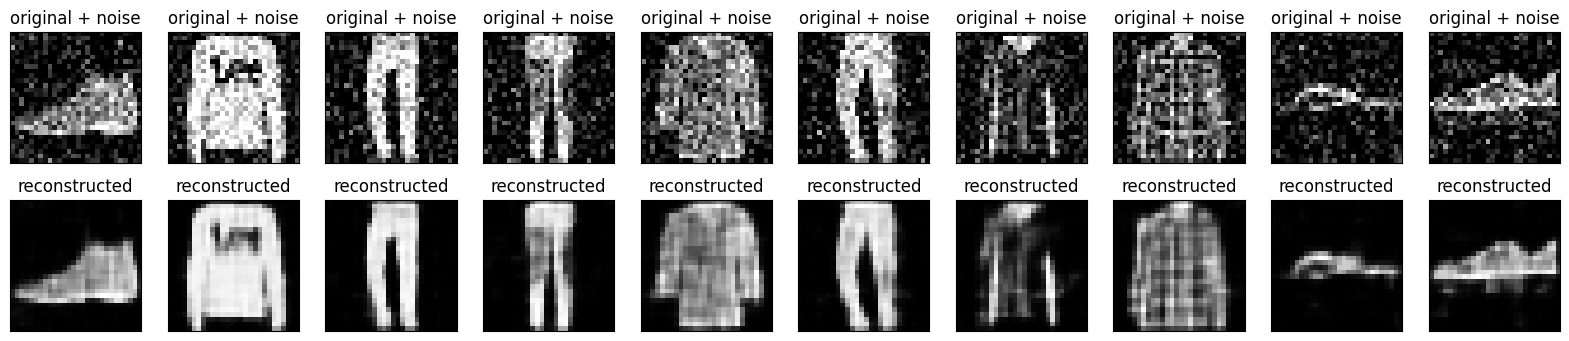

In [17]:
n=10
plt.figure(figsize=(20,4))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.title("original + noise")
  plt.imshow(x_test_noisy[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  bx = plt.subplot(2, n, i+1+n)
  plt.title("reconstructed")
  plt.imshow(decoded_imgs[i])
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
plt.show()